<a href="https://colab.research.google.com/github/rtphokie/FridayThe13FullMoon/blob/master/current_nws_warnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# https://www.weather.gov/
# these need to be installed, then included
try:
  from mpl_toolkits.basemap import Basemap
except:
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  !pip install matplotlib
  from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shutil
%matplotlib inline

#these are included in the standard python library, just need to import them
from pprint import pprint
import os

# These are DataSciencey so Google includes them in the container, just need to import them
import requests
import numpy as np
import yaml


def readconfig():
    significance={
        'W': 'Warning',
        'Y': 'Advisory',
        'A': 'Watch',
        'S': 'Statement',
        'F': 'Forecast',
        'O': 'Outlook',
        'N': 'Synopsis',
    }
    if not os.path.isfile('ww_colors.yml'):
      download_from_web('https://raw.githubusercontent.com/rtphokie/current_nws_warnings/master/ww_colors.yml', '.', 'ww_colors.yml')
    with open('ww_colors.yml') as file:
        data = yaml.load(file)
    return data, significance

def download_from_web(url, dir, filename, stream=False):
  print(f"fetching {url}")
  response = requests.get(url, stream=stream)
  if stream:
    with open(f"{dir}/{filename}", 'wb') as out_file:
      shutil.copyfileobj(response.raw, out_file)
  else:
    with open(f"{dir}/{filename}", 'w') as out_file:
      out_file.write(response.text)

  del response

def get_latest_shapes(dir, filename, drawbounds=False,
                      urlbase='https://mesonet.agron.iastate.edu/data/gis/shape/4326/us'):
                                 #https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.dbf
     if not os.path.exists(dir):
       os.makedirs(dir)
     for ext in ['dbf', 'shp', 'shx']:
         download_from_web(f'{urlbase}/{filename}.{ext}', dir, f'{filename}.{ext}', stream=True)

def draw_map(res, shadedrelief=False):
    # [c]rude (faster), [l]ow, [h]igh (slower)
    fig = plt.figure(figsize=(12, 8), dpi=300)
    m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                resolution=res )
    ax = fig.add_subplot(111)
    ax.set_facecolor('#E0FFFF')
    m.fillcontinents(color='#FAFAFA', ax=ax, zorder=0)
    m.drawcounties(ax=ax, color="#666666")
    m.drawstates(ax=ax, color='black')
    m.drawcountries(ax=ax)
    m.drawcoastlines(ax=ax)
    if shadedrelief:
      m.shadedrelief()
    return m, ax

print('done')

done


Let's make a map

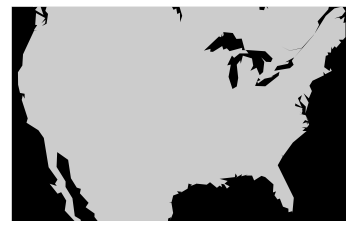

In [26]:
m0 = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
              projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
              resolution='c')

m0.fillcontinents()
plt.show()

Not very useful, let's add some borders

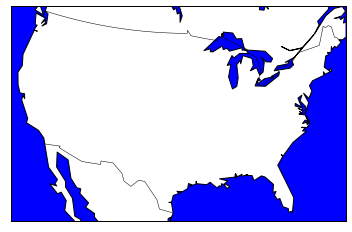

In [27]:
m1 = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                resolution='c')

m1.drawmapboundary(fill_color='blue')
m1.fillcontinents(color='w',lake_color='blue')
m1.drawcoastlines()
m1.drawcountries()

plt.show()

... add the states

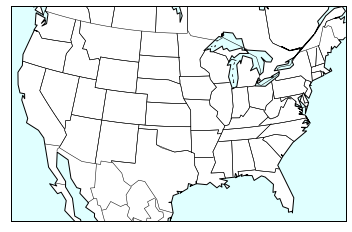

In [28]:
m3 = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                resolution='c')

m3.drawmapboundary(fill_color='#E0FFFF')
m3.fillcontinents(color='w',lake_color='#E0FFFF')
m3.drawcoastlines()
m3.drawcountries()
m3.drawstates(color='black')

plt.show()


Time for some data...

Download the latest alert data and shapefiles from Iowa State Mesonet

In [29]:
get_latest_shapes('IowaEnvMesonet', 'current_ww')

fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.dbf
fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.shp
fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.shx


read in the alert shapefile

(1266,
 5,
 [-152.82, 25.8, 0.0, 0.0],
 [-66.89, 70.89, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fbb56f91550>)

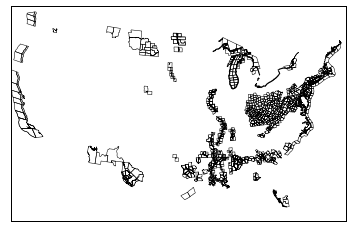

In [30]:
m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
            resolution='c')
m.drawmapboundary(fill_color='w')
m.readshapefile("IowaEnvMesonet/current_ww", 'current_ww')

<Figure size 432x288 with 0 Axes>

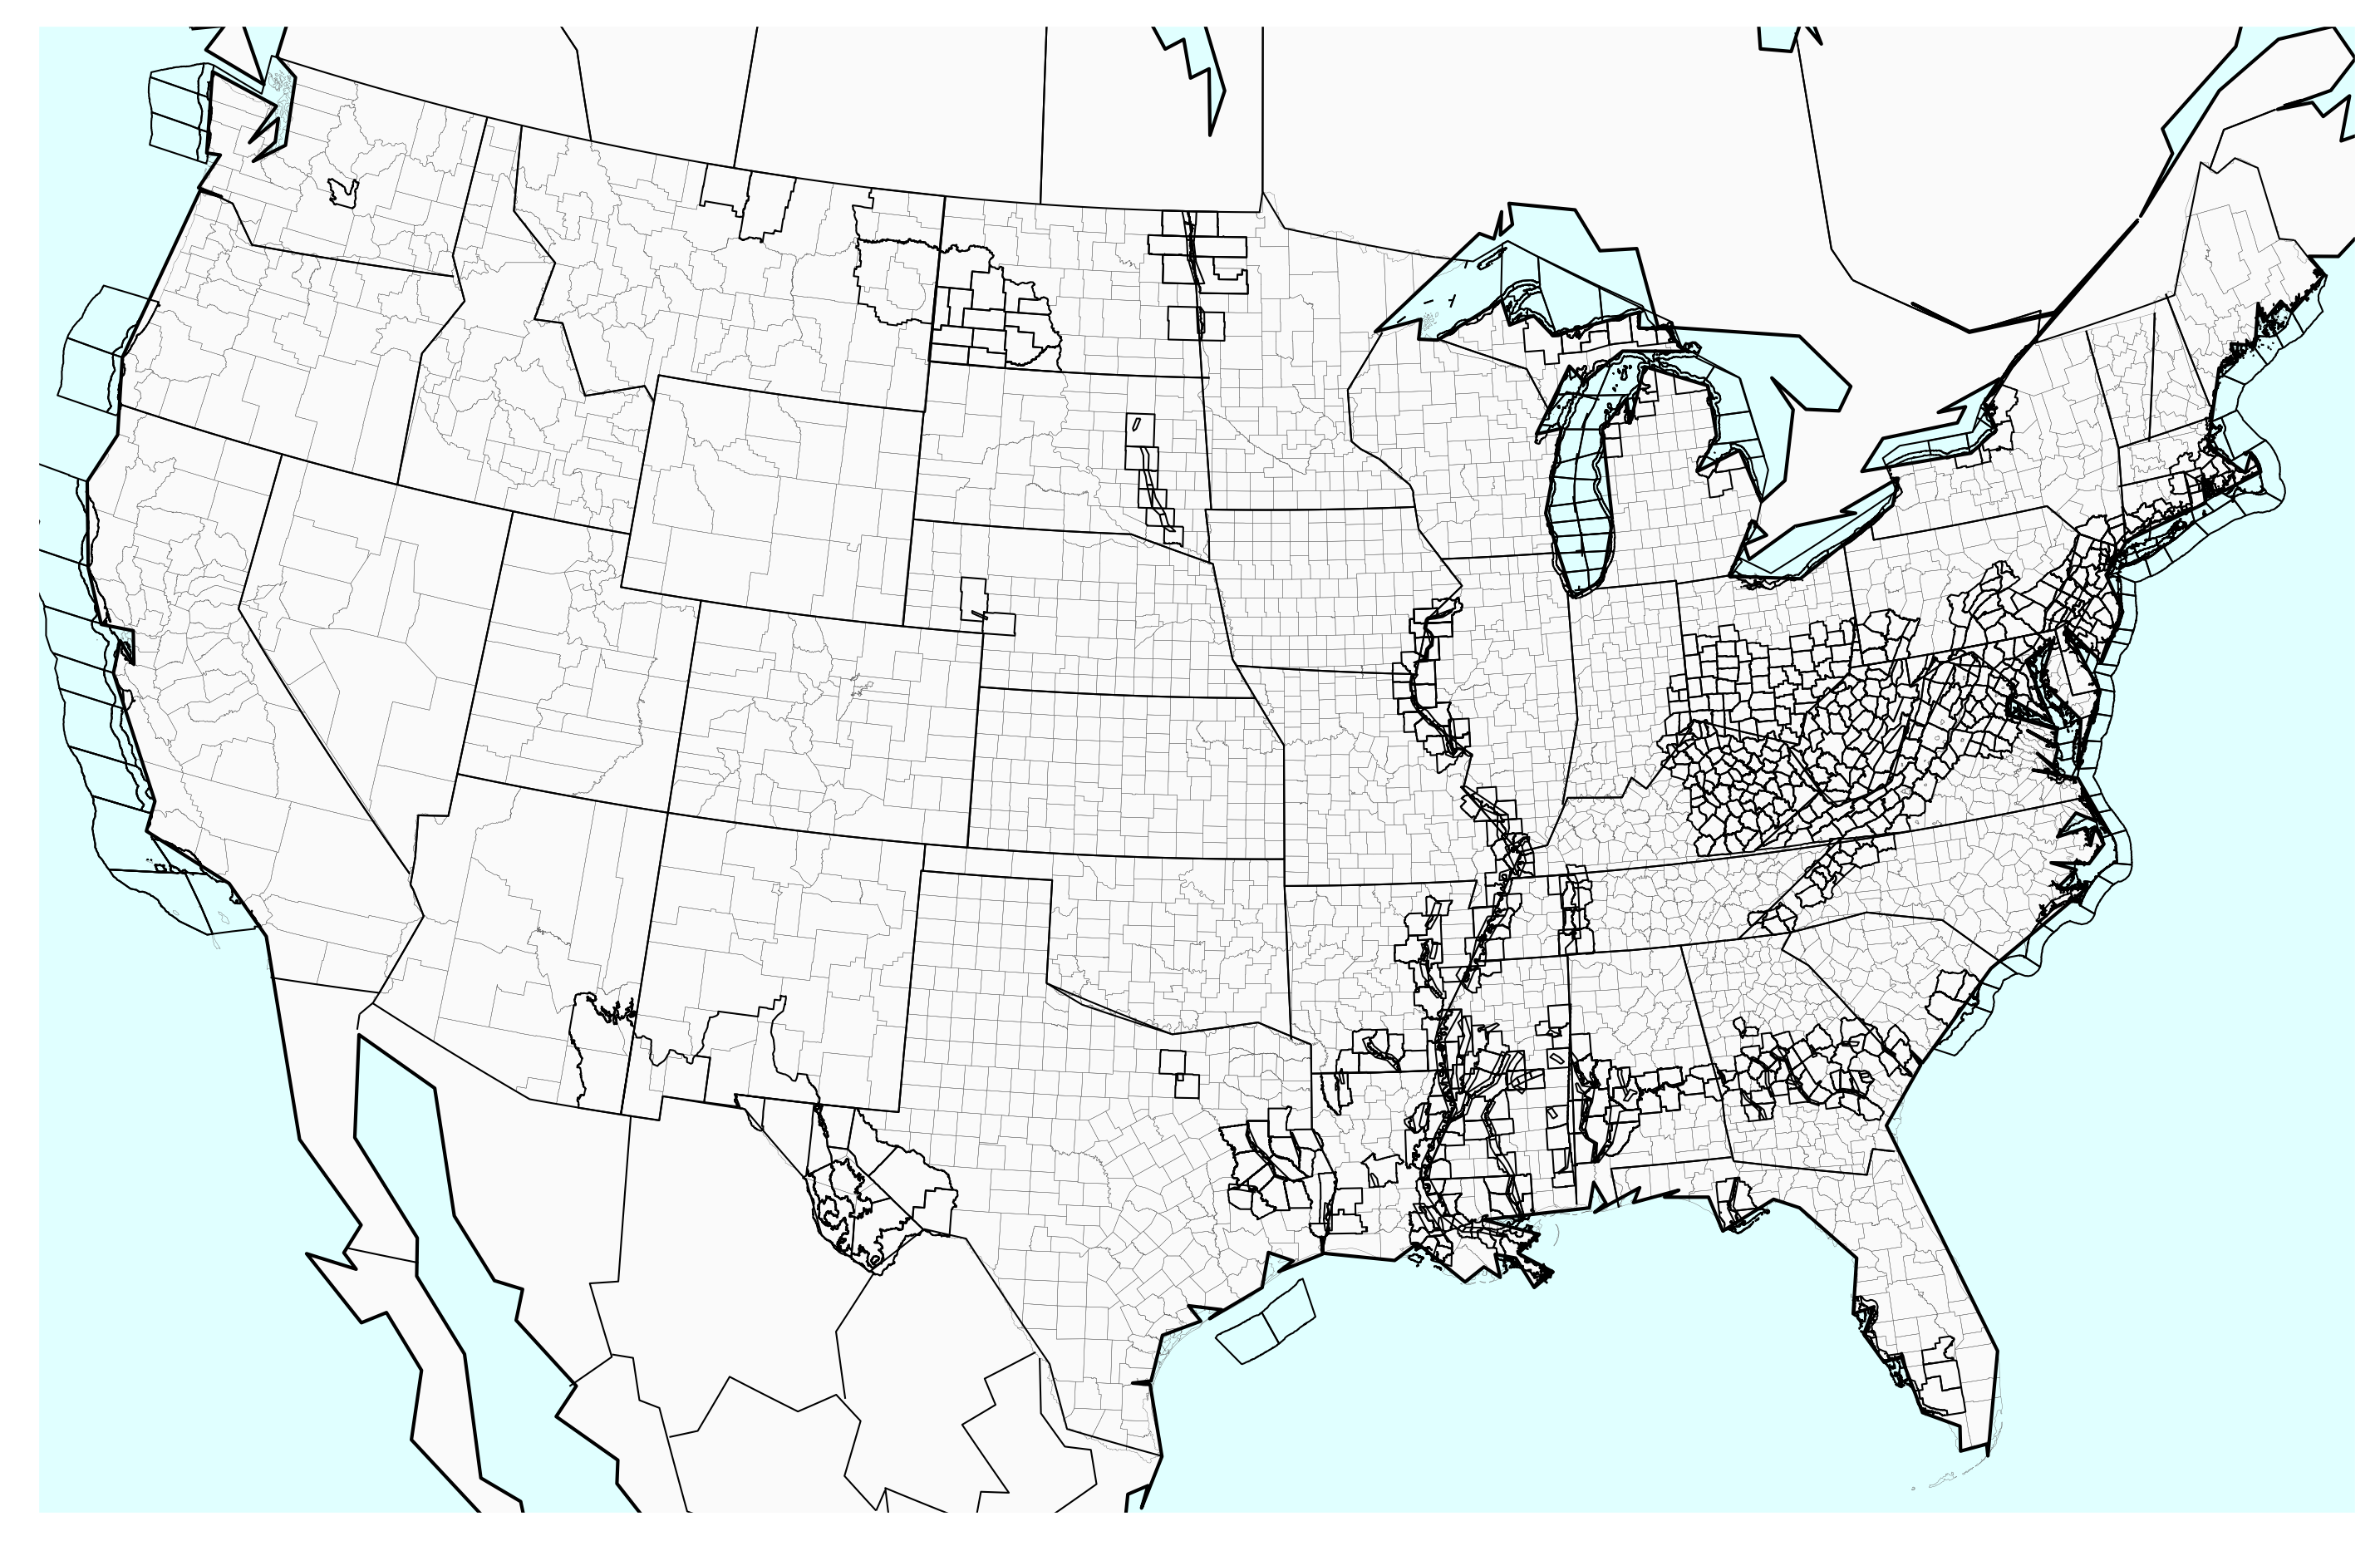

In [31]:
fig = plt.figure()
m, ax = draw_map('c')

m.readshapefile("IowaEnvMesonet/current_ww", 'current_ww')

plt.savefig('conus_ww_basic.png')

There's lots of different alerts there but they all look the same, let's add some color coding

<Figure size 432x288 with 0 Axes>

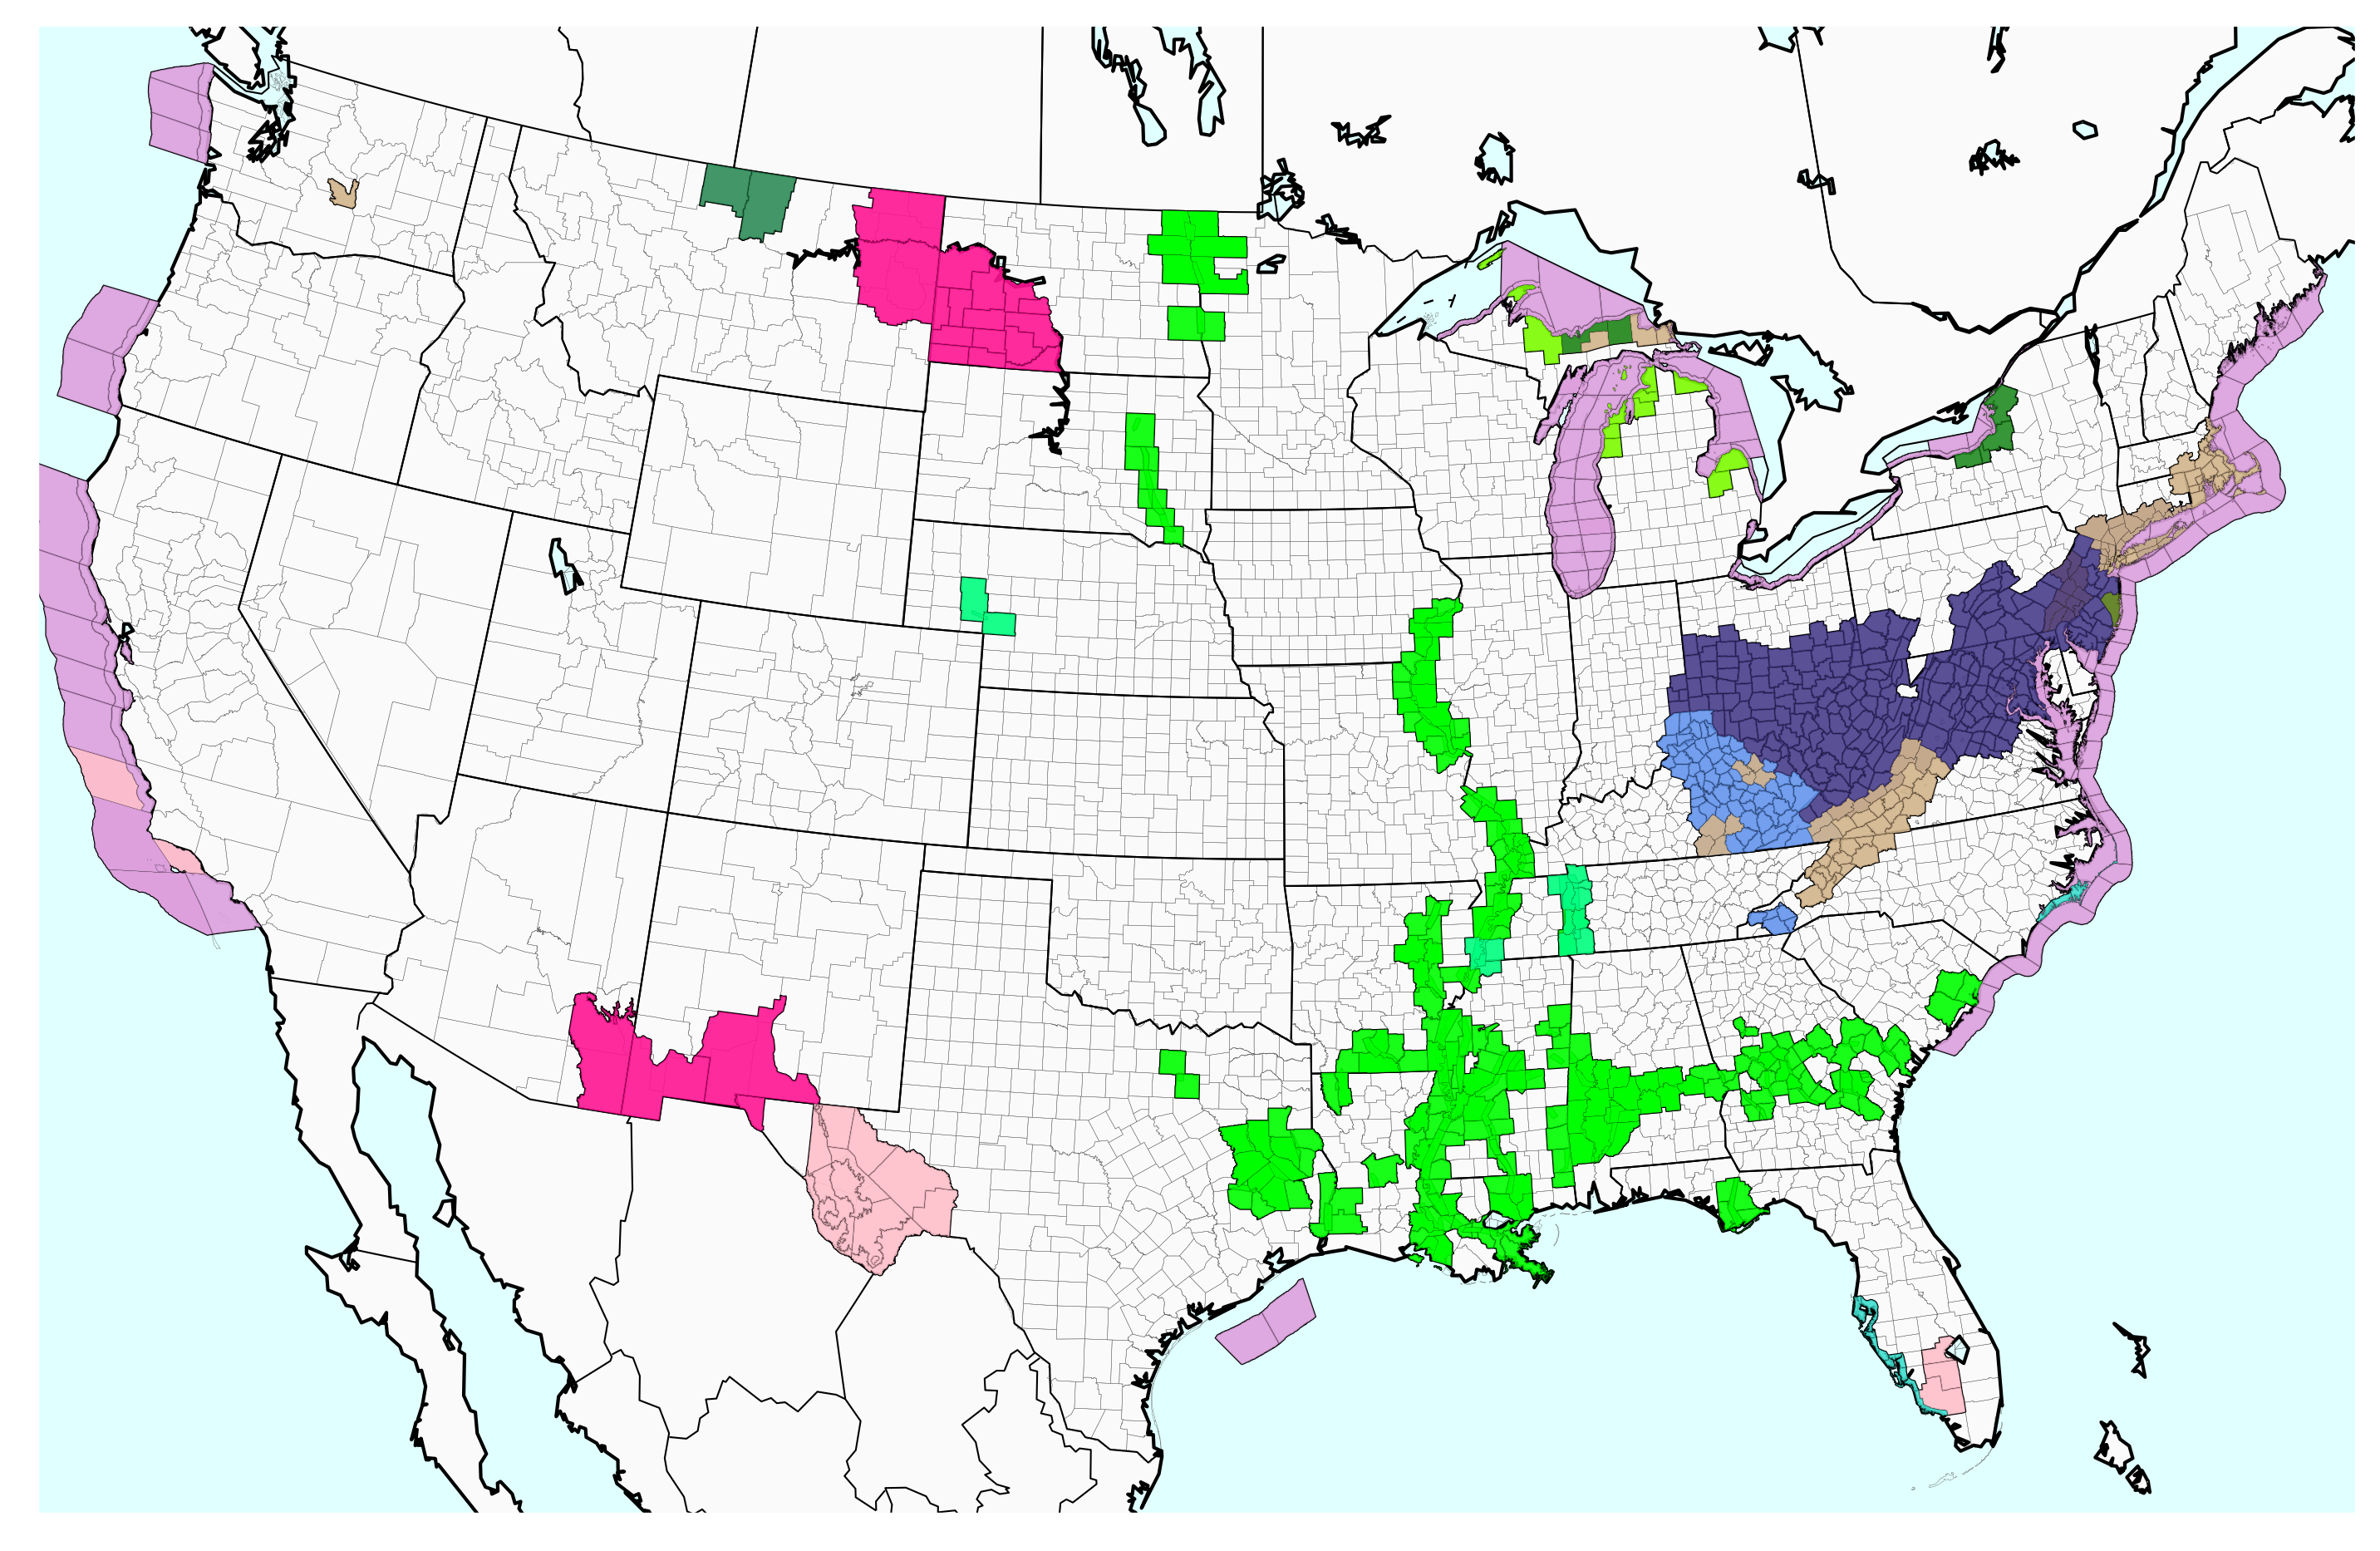

In [32]:
lookup, significance = readconfig()

fig = plt.figure()
m, ax = draw_map('l')

m.readshapefile("IowaEnvMesonet/current_ww", 'current_ww')
legend_labels = {}
patches = {}
for info, shape in zip(m.current_ww_info, m.current_ww):
    key = (info['PHENOM'], info['SIG'])
    if key not in patches.keys():
        patches[key] = []
    patches[key].append(Polygon(np.array(shape), True))

for key in patches.keys():
    phenom, sig = key
    color = lookup[phenom]['colors'][significance[sig].lower()]
    legend_labels[key] = f"{lookup[phenom]['description']} {significance[sig]}"

    if color == 'None':
        raise LookupError(f"need color for {legend_labels[key]}")
    ax.add_collection(PatchCollection(patches[key],
                                      facecolor=f"#{color}",
                                      edgecolor='k',
                                      label=key, alpha=.9,
                                      linewidths=.05, zorder=2))

plt.savefig('conus_ww.png')

A legend and title will make this more useful

<Figure size 432x288 with 0 Axes>

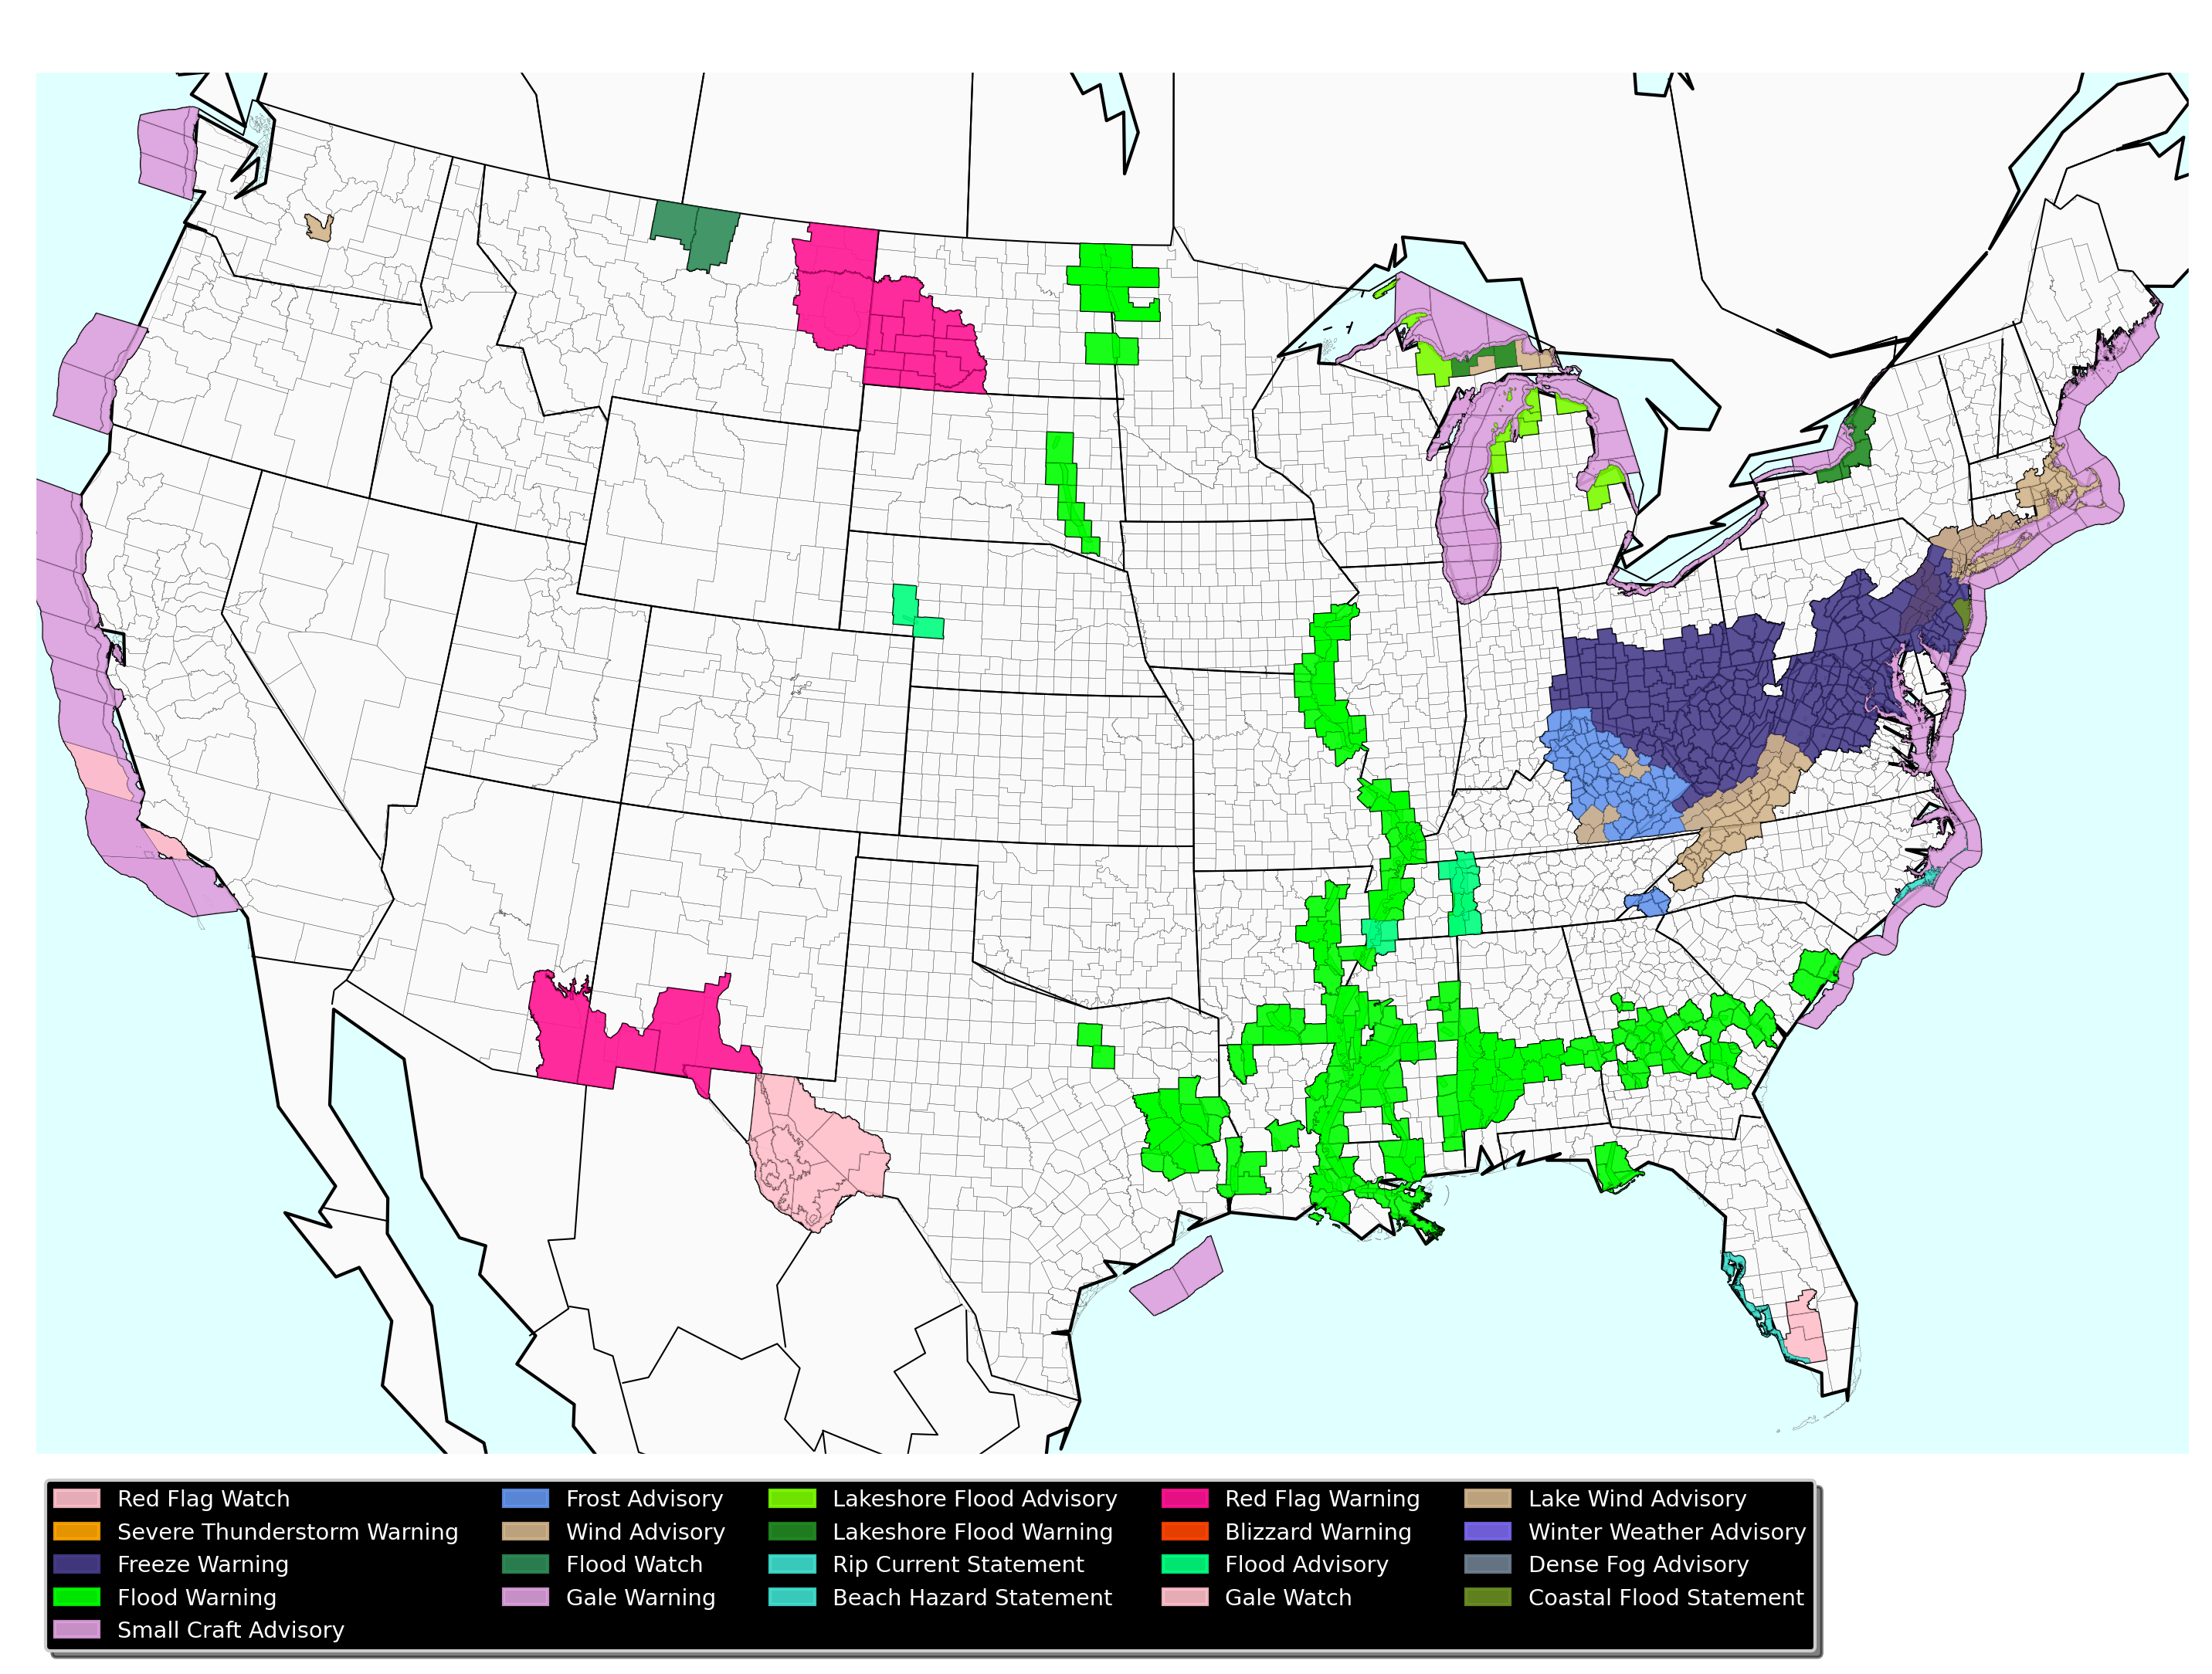

In [33]:
fig = plt.figure()
m, ax = draw_map('c')
plt.style.use('dark_background')

m.readshapefile("IowaEnvMesonet/current_ww", 'current_ww')

patches = {}
issuetimes = []
for info, shape in zip(m.current_ww_info, m.current_ww):
    key = (info['PHENOM'], info['SIG'])
    issuetimes.append(info['UPDATED'])

    if key not in patches.keys():
        patches[key] = []
    patches[key].append(Polygon(np.array(shape), True))


legenditems=[]
legend_labels = {}
for key in patches.keys():
    phenom, sig = key
    color = lookup[phenom]['colors'][significance[sig].lower()]
    legend_labels[key] = f"{lookup[phenom]['description']} {significance[sig]}"

    if color == 'None':
        raise LookupError(f"need color for {legend_labels[key]}")
    ax.add_collection(PatchCollection(patches[key],
                                      facecolor=f"#{color}",
                                      edgecolor='k',
                                      label=key, alpha=.9,
                                      linewidths=.05, zorder=2))
    legenditems.append(mpatches.Patch(color=f"#{color}", alpha=.9, label=legend_labels[key]
                                      ))

plt.legend(handles=legenditems,
           bbox_to_anchor=(0,-0.15,1,1), loc='lower left',
           fontsize='x-small', ncol=5, fancybox=True, shadow=True)
plt.title(f'Active Alerts {max(issuetimes)}Z')

plt.savefig('conus_ww.png')